In [6]:
!pip install torch
!pip install seaborn


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/7b/e5/83fcd7e9db036c179e0352bfcd20f81d728197a16f883e7b90307a88e65e/seaborn-0.13.0-py3-none-any.whl.metadata
  Using cached seaborn-0.13.0-py3-none-any.whl.metadata (5.3 kB)
Using cached seaborn-0.13.0-py3-none-any.whl (294 kB)

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [1]:
# Load helpers and custom dataset class
from __init__ import PricingWizardDataset, base_regression_pipeline, regression_accuracy, load_model, drop_helpers, ridge_regression_pipeline, threshold_accuracy

# Data manipulation 
import pandas as pd
import numpy as np
import os
import time
import math
import zipfile

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
# Load Data
data = PricingWizardDataset()

Dataset Loaded: post_preprocessing_without_dummies
	Number of Rows: 283055
	Number of Columns: 22
	Outlier Removal: True
	Train Size: 0.8
	Test Size: 0.2
	Random State: 42


## Load model

In [3]:
# Current working directory
cwd = os.getcwd()

# model directory
model_dir = os.path.join(cwd, 'models', 'pickled_models')

with zipfile.ZipFile(f'{model_dir}/prediction_random_forest.pkl.zip', 'r') as zip_ref:
    # Extract all contents to the specified directory
    zip_ref.extractall(model_dir)

random_forest = load_model(f'{model_dir}/prediction_random_forest.pkl')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.3.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Model loaded successfully from /Users/albertobfilho/Repositories/data-mining/pricing_wizards/models/pickled_models/prediction_random_forest.pkl


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.3.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
random_forest

RandomForestRegressor(max_depth=20, min_samples_leaf=2, min_samples_split=10)

## Random Forest - Ordinal Encoding

In [16]:
# Apply data preparation
print('Applying data preparation...')
data.apply_function(base_regression_pipeline)
print('Done.')

Applying data preparation...
Done.


In [17]:
# Split data
data.stratify_train_test_split(y_column='log_listing_price',
                               val_size=0,
                               return_splits=False)

Dependent variable distribution is equal across all subsets


In [18]:
# Evaluate the model using cross-validation and calculates the mean
cv_scores: list = cross_val_score(random_forest, drop_helpers(data.X_train), data.y_train, scoring='neg_mean_squared_error', cv=5)
mse_mean_cv: float = -np.mean(cv_scores)

# Train the final model on the entire training set, measuring the training time in seconds
start_time = time.time()
random_forest.fit(drop_helpers(data.X_train), data.y_train)
end_time = time.time()

# Calculate training time
training_time = end_time - start_time

# Evaluate the final model on the test set
y_pred_test_base = random_forest.predict(drop_helpers(data.X_test))

y_test_base = data.y_test
regression_accuracy(y_pred_test_base, y_test_base)
print("Cross-validation Score:", mse_mean_cv)
print("Training Time:", training_time)

R2 Score: 0.6507701718886372
MSE: 0.3364753267221235
MAE 0.43477014532614494
RMSE 0.5800649331946583
Cross-validation Score: 0.341146642297781
Training Time: 15.342416048049927


In [19]:
# Calculate permutation importances for the regressor to have a similar metric between the models
feature_importances_values = permutation_importance(random_forest, drop_helpers(data.X_test), y_test_base, n_repeats=10, random_state=42).importances_mean
feature_importance = pd.DataFrame({'Feature': drop_helpers(data.X_train).columns, 'Importance': feature_importances_values})
feature_importance.sort_values(by='Importance', ascending=False)

,Feature,Importance
0,brand_name,0.880118
2,subsubsubcategory_name,0.377746
1,condition_name,0.135301


In [20]:
# Feature importance based on regressor coefficients
feature_importances = random_forest.feature_importances_
feature_importance = pd.DataFrame({'Feature': drop_helpers(data.X_train).columns, 'Coef': feature_importances})
feature_importance.sort_values(by='Coef', ascending=False)

,Feature,Coef
0,brand_name,0.747216
2,subsubsubcategory_name,0.185622
1,condition_name,0.067161


In [21]:
data.reset_dataset()

## Random Forest - OHE

#### This model uses the same features as the ordinal encoding but fits with OHE

In [47]:
data.df = data.df[["log_listing_price", "brand_name", "subsubsubcategory_name", "condition_name"]]

In [48]:
# Split data
data.stratify_train_test_split(y_column='log_listing_price',
                               val_size=0,
                               return_splits=False)

Dependent variable distribution is equal across all subsets


In [50]:
# Identify categorical columns
categorical_columns = drop_helpers(data.X_train).select_dtypes(include=['object']).columns

# Create a ColumnTransformer to apply OneHotEncoder to categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ]
)

# Create a pipeline with preprocessing and Random Forest
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', random_forest)
])

cv_scores: list = cross_val_score(pipeline, drop_helpers(data.X_train), data.y_train, scoring='neg_mean_squared_error', cv=5)
mse_mean_cv: float = -np.mean(cv_scores)

# Fit the pipeline on the training data
pipeline.fit(drop_helpers(data.X_train), data.y_train)

# Evaluate the final model on the test set
y_pred_test_ohe = pipeline.predict(drop_helpers(data.X_test))

# Evaluate the model
y_test_ohe = data.y_test
regression_accuracy(y_pred_test_ohe, y_test_ohe)
print("Cross-validation Score:", mse_mean_cv)

R2 Score: 0.3704182840740674
MSE: 0.606588259399486
MAE 0.6001274779913767
RMSE 0.7788377619244499
Cross-validation Score: 0.6102509400753737


In [51]:
# Calculate permutation importances for the regressor to have a similar metric between the models
permut_importances = permutation_importance(pipeline, drop_helpers(data.X_test), y_test_ohe, n_repeats=10, random_state=42).importances_mean
feature_importance = pd.DataFrame({'Feature': drop_helpers(data.X_train).columns, 'Importance': permut_importances})
feature_importance.sort_values(by='Importance', ascending=False)

,Feature,Importance
1,subsubsubcategory_name,0.330269
0,brand_name,0.305892
2,condition_name,0.094727


In [ ]:
data.reset_dataset()

# Visualizations

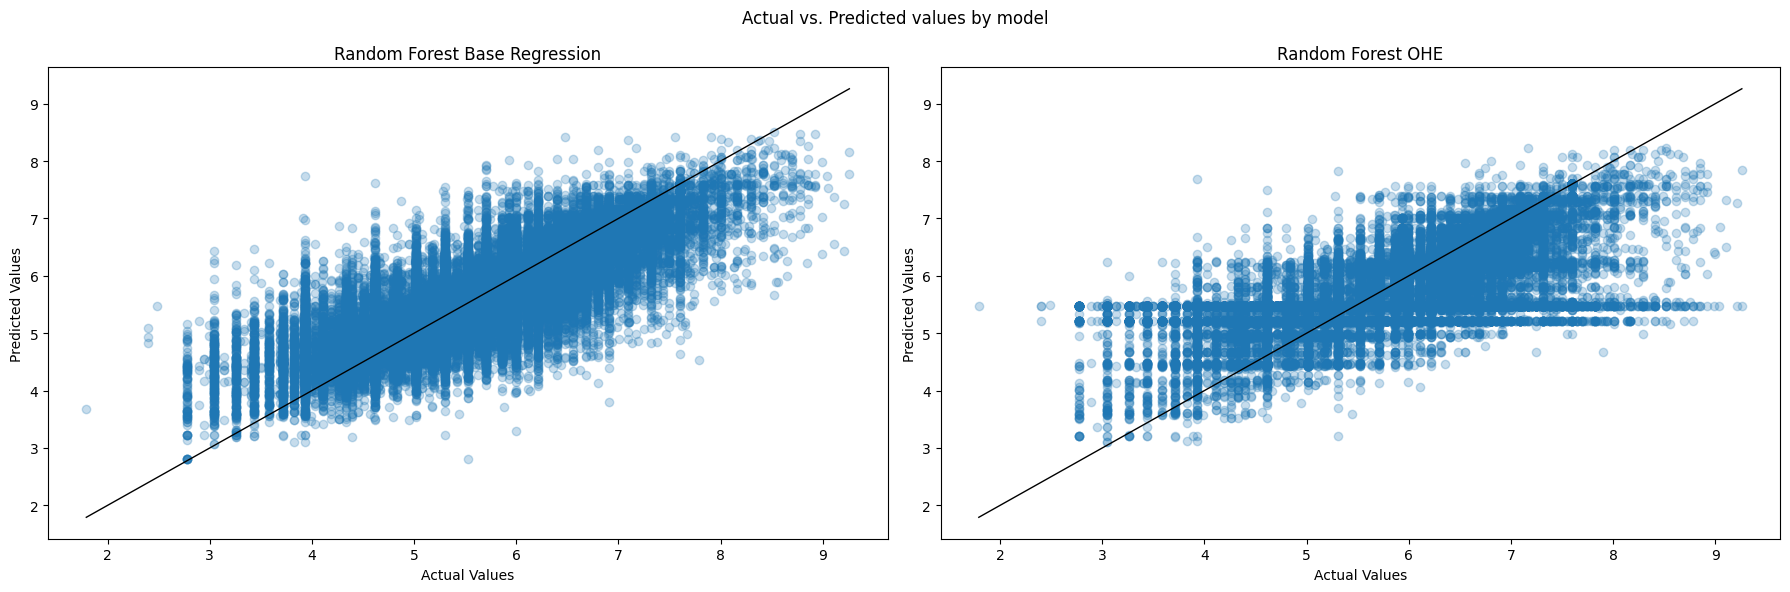

In [37]:
# actual vs predicted
pipelines = [(y_pred_test_base, y_test_base), (y_pred_test_ohe, y_test_ohe)]
labels= ["Random Forest Base Regression", "Random Forest OHE", "Random Forest OHE Reduced"]

num_pipelines = len(pipelines)
num_cols = 2
num_rows = math.ceil(num_pipelines / num_cols)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 6*num_rows), tight_layout=True)
axs = axs.flatten()

for i, (y_pred, y_test) in enumerate(pipelines):
    axs[i].scatter(y_test, y_pred, alpha=0.25)
    axs[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k', lw=1)
    axs[i].set_title(labels[i])
    axs[i].set_xlabel('Actual Values')
    axs[i].set_ylabel('Predicted Values')

plt.suptitle("Actual vs. Predicted values by model")

plt.show(fig)

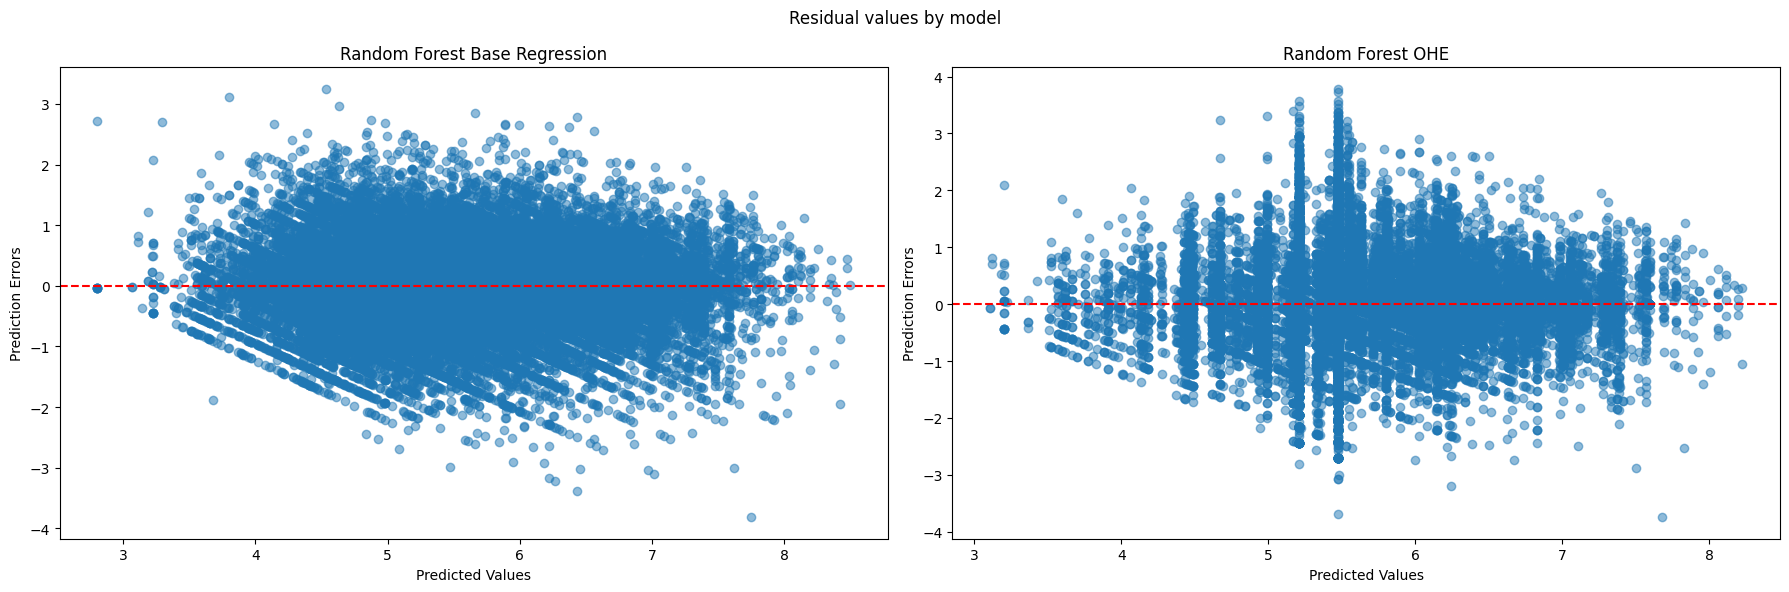

In [38]:
pipelines = [(y_pred_test_base, y_test_base), (y_pred_test_ohe, y_test_ohe)]
labels= ["Random Forest Base Regression", "Random Forest OHE", "Random Forest OHE Reduced"]

num_pipelines = len(pipelines)
num_cols = 2
num_rows = math.ceil(num_pipelines / num_cols)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 6*num_rows), tight_layout=True)

for i, (y_pred, y_test) in enumerate(pipelines):
    # Calculate residuals
    prediction_error = y_test - y_pred

    # Plot the scatter plot on the specific subplot
    axs[i].scatter(y_pred, prediction_error, alpha=0.5)
    axs[i].axhline(y=0, color='r', linestyle='--')
    axs[i].set_title(labels[i])
    axs[i].set_xlabel('Predicted Values')
    axs[i].set_ylabel('Prediction Errors')

plt.suptitle("Residual values by model")
plt.show()